### Twitter Hate Speech Analysis
When working on a supervised machine learning problem with a given data set, we try different algorithms and techniques to search for models to produce general hypotheses, which then make the most accurate predictions possible about future instances. The same principles apply to text (or document) classification where there are many models can be used to train a text classifier. 

We are going tp train multiple models to compare and decide which one is the best model.

### The Data
The data we are using from twitter.The data file contains 5 columns:

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [1]:
import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit
import gensim
import re
import logging
from numpy import random
from bs4 import BeautifulSoup

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from gensim.models import Word2Vec  

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline



#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
#warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('labeled_data.csv')
#df = df[pd.notnull(df['class'])]
#df = df.head(5000)
print(df.head(10))
print(df['tweet'].apply(lambda x: len(x.split(' '))).sum())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   
5           5      3            1                   2        0      1   
6           6      3            0                   3        0      1   
7           7      3            0                   3        0      1   
8           8      3            0                   3        0      1   
9           9      3            1                   2        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Da

We have over 3 million words in. tweets

In [3]:
#0 - hate speech 1 - offensive language 2 - neitherda
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [4]:
df['class']=[1 if b == 2 else 0 for b in df['class']]
# Transform into binary classification
#df['class'] = [1 if b == 2 else 0 for b in df['class']]
df['class'].value_counts()

0    20620
1     4163
Name: class, dtype: int64

Text(0,0.5,'count')

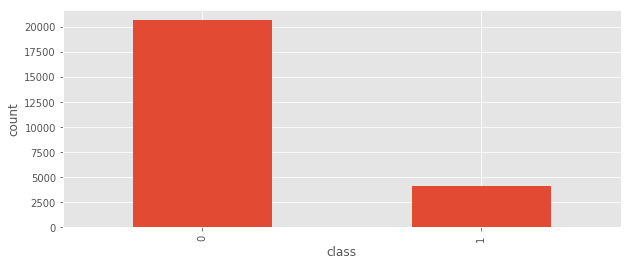

In [5]:
# Shape of our data
df.columns
df.head(10)
plt.figure(figsize=(10,4))
ax=df['class'].value_counts().plot(kind='bar');
ax.set_xlabel("class")
ax.set_ylabel("count")

### Text Pre-processing
The text cleaning techniques we have seen so far work very well in practice. Depending on the kind of texts you may encounter, it may be relevant to include more complex text cleaning steps. But keep in mind that the more steps we add, the longer the text cleaning will take.
For this particular data set, our text cleaning step includes HTML decoding, remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['tweet'] = df['tweet'].apply(clean_text)
df.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,1,rt mayasolovely woman shouldnt complain cleani...
1,1,3,0,3,0,0,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,2,3,0,3,0,0,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,3,3,0,2,1,0,rt c_g_anderson viva_based look like tranny
4,4,6,0,6,0,0,rt shenikaroberts shit hear might true might f...
5,5,3,1,2,0,0,t_madison_x shit blows meclaim faithful somebo...
6,6,3,0,3,0,0,__brighterdays sit hate another bitch got much...
7,7,3,0,3,0,0,selfiequeenbri cause im tired big bitches comi...
8,8,3,0,3,0,0,might get ya bitch back thats
9,9,3,1,2,0,0,rhythmixx_ hobbies include fighting mariambitch


In [7]:
df['tweet'].apply(lambda x: len(x.split(' '))).sum()

227320

After text cleaning and removing stop words, we have only over 2 million words to work with!
After splitting the data set, the next steps includes feature engineering. 
We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers from Scikit-Learn library.

In [8]:
X = df.tweet
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = 42)

### Naive Bayes Classifier for Multinomial Models
After we have our features, we can train a classifier to try to predict the tag of a post. We will start with a Naive Bayes classifier, which provides a nice baseline for this task.

scikit-learn includes several variants of this classifier; the one most suitable for text is the multinomial variant.

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn that behaves like a compound classifier.

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

#%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8432052937378954
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     10301
           1       0.98      0.07      0.13      2091

   micro avg       0.84      0.84      0.84     12392
   macro avg       0.91      0.54      0.52     12392
weighted avg       0.86      0.84      0.78     12392



Achieved 84% Accuracy

## Linear Support Vector Machine
Linear Support Vector Machine is widely regarded as one of the best text classification algorithms.


In [11]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

#%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8487734021949644
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10301
           1       0.91      0.12      0.21      2091

   micro avg       0.85      0.85      0.85     12392
   macro avg       0.88      0.56      0.56     12392
weighted avg       0.86      0.85      0.80     12392



/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


### Logistic Regression
Logistic regression is a simple and easy to understand classification algorithm, and Logistic regression can be easily generalized to multiple classes.

In [12]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

#%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9310038734667527
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10301
           1       0.83      0.75      0.79      2091

   micro avg       0.93      0.93      0.93     12392
   macro avg       0.89      0.86      0.87     12392
weighted avg       0.93      0.93      0.93     12392



/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
